# Euler integration method

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's start by considering the simplest form of Euler's method.

Given a system of ODEs of the form

$\frac{dx}{dt} = f(x)$,

we approximate it according to the following expression:

$f(x) = \frac{dx}{dt} = \lim_{\Delta t\rightarrow0} \frac{x(t+\Delta t) - x(t)}{\Delta t} \approx \frac{x(t+\Delta t) - x(t)}{\Delta t}$,

which is valid when $\Delta t$ is small enough (relative to the characteristic time(s) of the system we are considering).
We can therefore write the iterative expression for the _approximate_ solution $x(t)$ as

$x(t+h) = x(t) + \Delta t f(x(t))$.

As an iterative rule, this reads

$x_{n+1} = x_n + \Delta t f(x_n)$

The following code implements this formula:

In [2]:
def euler(func, t_span, y0, h):
    n_dim = len(y0)
    t = np.arange(t_span[0],t_span[1],h)
    n_steps = len(t)
    y = np.zeros((n_dim,n_steps))
    y[:,0] = y0
    for i in range(n_steps-1):
        y[:,i+1] = y[:,i] + h * func(t[i],y[:,i]) 
    return t,y

One of the downsides of Euler's method is that it uses the derivative $f(x)$ only in $x_n$, i.e., at the left end of each time interval. We can therefore improve the method by first estimating the solution at step $n+1$ using the standard method (which we shall call $\tilde{x}_{n+1}$, computing the derivative $f(\tilde{x}_{n+1})$ and then calculating the next solution $x_{n+1}$ by using a weighted average of the values of the derivative at _both_ ends of the time interval.

In formulas, this reads

$\tilde{x}_{n+1} = x_n + \Delta t f(x_n)$

$x_{n+1} = x_n + \frac{1}{2} \Delta t \left[ f(x_n) + f(\tilde{x}_{n+1}) \right]$

The following code implements this formula:

In [3]:
def euler_midpoint(func, t_span, y0, h):
    n_dim = len(y0)
    t = np.arange(t_span[0],t_span[1],h)
    n_steps = len(t)
    y = np.zeros((n_dim,n_steps))
    y[:,0] = y0
    half_h = h/2
    for i in range(n_steps-1):
        fy = func(t[i],y[:,i])
        y_guess = y[:,i] + h * fy
        y[:,i+1] = y[:,i] + half_h * (fy + func(t[i+1],y_guess)) 
    return t,y

### The system
For this example, we use the following logistic equation (see [here](Logistic_equation.ipynb) for more information about this system):

$\dot{N} = r N (1-\frac{N}{k})$

In [4]:
logistic = lambda t,N,r,k: r*N*(1-N/k)
r,k = 0.1,10
# characteristic time constant
τ = 1/r
func = lambda t,x: logistic(t,x,r,k)
jac = lambda t,x: logistic_jac(t,x,r,k)

### Perform the integration

In [5]:
N0 = 1e-3
tspan = [0,20*τ]
dt = 0.05*τ
t = np.r_[tspan[0] : tspan[1] : dt]
# Conventional Euler
t_fw,y_fw = euler(func, tspan, [N0], dt)
# Improved Euler
t_fw_imp,y_fw_imp = euler_midpoint(func, tspan, [N0], dt)
# Runge-Kutta of order 5(4)
sol = solve_ivp(func, tspan, [N0], rtol=1e-6, atol=1e-8, method='RK45')

In [6]:
print('Runge-Kutta computed the solution at {} time instants.'.format(sol.t.size))
print('Euler used {} points.'.format(t.size))

Runge-Kutta computed the solution at 51 time instants.
Euler used 400 points.


### The exact solution
Given $N(t_0) = N_0$, the solution to the previous ODE can be computed analytically:

$N(t) = \frac{k}{1 + A\mathrm{e}^{-rt}}$,

with $A=\frac{k}{N_0}-1$.

In [7]:
sol_exact = lambda t,r,k,N0: k/(1+(k/N0-1)*np.exp(-r*t))
y = sol_exact(t, r, k, N0)
# we also calculate the exact solution at the time instants where solve_ivp computes its solution
y_ds = sol_exact(sol.t, r, k, N0)

### Plot the results

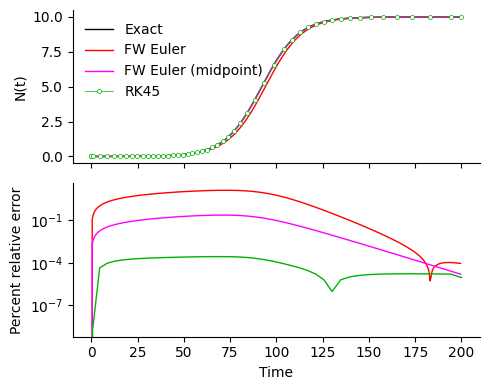

In [8]:
fig,ax = plt.subplots(2, 1, figsize=(5,4), sharex=True)

red = [1,0,0]
green = [0,.7,0]
magenta = [1,0,1]
ax[0].plot(t, y, 'k', lw=1, label='Exact')
ax[0].plot(t_fw, y_fw[0], lw=1, color=red, label='FW Euler')
ax[0].plot(t_fw, y_fw_imp[0], lw=1, color=magenta, label='FW Euler (midpoint)')
ax[0].plot(sol.t, sol.y[0], 'o-', markerfacecolor='w', markersize=3, markeredgewidth=0.5,
           lw=0.5, color=green, label='RK45')
ax[0].legend(loc='upper left', frameon=False)
ax[0].set_ylabel('N(t)')

ax[1].plot(t, np.abs(y-y_fw[0])/y*100, lw=1, color=red)
ax[1].plot(t, np.abs(y-y_fw_imp[0])/y*100, lw=1, color=magenta)
ax[1].plot(sol.t, np.abs(y_ds-sol.y[0])/y_ds*100, lw=1, color=green)
ax[1].set_yscale('log')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Percent relative error')

sns.despine()
fig.tight_layout()